In [1]:
import numpy as np
import os
import masknmf
import sys
import torch

import tifffile
import fastplotlib as fpl
from imgui_bundle import imgui
from fastplotlib import ui

import matplotlib.pyplot as plt

import time
from typing import *
%matplotlib inline
%load_ext autoreload

fastplotlib version from git (0.2.0) and __version__ (0.5.0) don't match.
No windowing system present. Using surfaceless platform
No config found!
No config found!
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA TITAN RTX,DiscreteGPU,Vulkan,555.42.02
❗ limited,"llvmpipe (LLVM 12.0.0, 256 bits)",CPU,Vulkan,Mesa 21.2.6 (LLVM 12.0.0)
❌,NVIDIA TITAN RTX/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 555.42.02


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


In [2]:
# Load the masknmf moco 
masknmfmoco_file = "demoMovie.tif"
data = tifffile.imread(masknmfmoco_file)

RFBOutputContext()

Max vertex attribute stride unknown. Assuming it is 2048
/data/home/app2139/fastplotlib/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
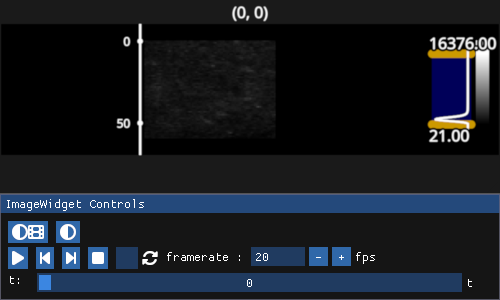

In [4]:
iw = fpl.ImageWidget(data = data)
iw.cmap = "gray"
iw.show()

In [3]:
full_moco_dense = data

In [4]:
pmd_arr_moco = masknmf.compression.pmd_decomposition(full_moco_dense,
                                                [20, 20],
                                                full_moco_dense.shape[0],
                                                max_components = 20,
                                                max_consecutive_failures=3,
                                                background_rank = 4,
                                               device = "cuda",
                                               pixel_weighting=None,
                                               frame_batch_size = 1024)

[25-05-15 12:20:35]: Starting compression
[25-05-15 12:20:35]: sampled from the following regions: [0]
[25-05-15 12:20:35]: We are initializing on a total of 2000 frames
[25-05-15 12:20:36]: Approximating full FOV basis terms
[25-05-15 12:20:36]: Loading data to estimate complete spatial basis
[25-05-15 12:20:36]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 279.68it/s]

[25-05-15 12:20:37]: Running Blockwise Decompositions


[25-05-15 12:20:37]: Constructed U matrix. Rank of U is 704
[25-05-15 12:20:37]: PMD Objected constructed


In [5]:
pmd_arr_moco.to('cuda')
pmd_arr_moco.rescale = False

In [9]:
full_moco_dense.shape

(2000, 60, 80)

In [5]:
from functools import partial
from ipywidgets import VBox, HBox
from collections import OrderedDict
import pygfx

In [ ]:
iw = fpl.ImageWidget(
    [full_moco_dense, pmd_arr_moco],
    names=["mcorr", "pmd"],
)

mcorr_img = iw.managed_graphics[0]
pmd_img = iw.managed_graphics[1]

image_graphics = [
    mcorr_img,
    pmd_img,
]

fig_temporal = fpl.Figure(shape=(1, 2), names=["mcorr", "pmd"])
fig_temporal["mcorr"].add_line(np.zeros(full_moco_dense.shape[0]))
fig_temporal["pmd"].add_line(np.zeros(pmd_arr_moco.shape[0]))

mcorr_selectors = list()
pmd_selectors = list()

rect_selector_kwargs = dict(
    edge_thickness=1, 
    edge_color="w", 
    vertex_thickness=3.0, 
    vertex_color="cyan"
)

selectors = OrderedDict()

for img in image_graphics:
    selectors[img] = list()

# mcorr_selectors.append(
#     mcorr_img.add_rectangle_selector(
#         selection=[0, 20, 0, 20],
#         **rect_selector_kwargs
#     )
# )
# pmd_selectors.append(
#     pmd_img.add_rectangle_selector(
#         selection=[0, 20, 0, 20],
#         **rect_selector_kwargs
#     )
# )

# selectors = [
#     mcorr_selectors,
#     pmd_selectors,
# ]

def rect_selector_moved(selectors_pair: tuple[fpl.RectangleSelector], ev: fpl.GraphicFeatureEvent):
    for selector in selectors_pair:
        selector.selection = ev.info["value"]
    
    row_ixs, col_ixs = ev.get_selected_indices()
    row_slice = slice(row_ixs[0], row_ixs[-1] + 1)
    col_slice = slice(col_ixs[0], col_ixs[-1] + 1)

    mcorr_temporal = full_moco_dense[:, row_slice, col_slice].mean(axis=(1, 2)).ravel()
    pmd_temporal = pmd_arr_moco[:, row_slice, col_slice].mean(axis=(1, 2)).ravel()

    fig_temporal["mcorr"].graphics[0].data[:, 1] = mcorr_temporal
    fig_temporal["pmd"].graphics[0].data[:, 1] = pmd_temporal

    for subplot in fig_temporal:
        subplot.auto_scale()

# for pair in zip(*selectors):
#     for sel in pair:
#         sel.add_event_handler(partial(rect_selector_moved, pair), "selection")

class ROIManager(ui.EdgeWindow):
    def __init__(self, figure, size):
        super().__init__(
            figure=figure,
            size=size,
            location="right",
            title="ROI Selector"
        )

        self.add_rois_mode = False

    def update(self):
        _, self.add_rois_mode = imgui.checkbox("Add ROI", self.add_rois_mode)

roi_manager = ROIManager(iw.figure, size=100)
iw.figure.add_gui(roi_manager)

RESIZING_NEW_RECT = False


def add_rectangle(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT

    if not roi_manager.add_rois_mode:
        return
    
    if ev.button != 1:
        return

    for subplot in iw.figure:
        subplot.controller.enabled = False
        
    # in world space
    x, y = ev.pick_info["index"]

    new_selectors = list()
    
    for subplot in iw.figure:
        if len(subplot.graphics) < 1:
            continue  # empty subplot
            
        img = subplot["image_widget_managed"]
        new_selector = img.add_rectangle_selector(
            selection=[x, x + 1, y, y + 1],
            **rect_selector_kwargs
        )
    
        if len(selectors[img]) > 0:
            old_selector = selectors[img].pop()
            subplot.remove_graphic(old_selector)
            
        selectors[img].append(new_selector)
        new_selectors.append(new_selector)

    for sel in new_selectors:
        sel.add_event_handler(partial(rect_selector_moved, new_selectors), "selection")

    RESIZING_NEW_RECT = True


for img in image_graphics:
    img.add_event_handler(add_rectangle, "pointer_down")


@iw.figure.renderer.add_event_handler("pointer_move")
def resize_rect(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT
    
    if not RESIZING_NEW_RECT:
        return

    img = image_graphics[0]

    for subplot in iw.figure:
        # world (x, y)
        pos = subplot.map_screen_to_world(ev)
        if pos is None:
            continue
        else:
            break

    if pos is None:
        # if pointer was moved outside the subplot
        RESIZING_NEW_RECT = False
        return

    x2, y2, _ = pos

    # most recently added selector
    x1, _, y1, _ = selectors[img][-1].selection
    
    selectors[img][-1].selection = [x1, x2, y1, y2]


@iw.figure.renderer.add_event_handler("pointer_up")
def end_resize(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT
    
    if ev.button != 1:
        return
    if not RESIZING_NEW_RECT:
        return

    for subplot in iw.figure:
        subplot.controller.enabled = True
    
    RESIZING_NEW_RECT = False


HBox([iw.show(), fig_temporal.show(maintain_aspect=False)])

In [23]:
class ROIManager(ui.EdgeWindow):
    def __init__(self, figure, size):
        super().__init__(
            figure=figure,
            size=size,
            location="right",
            title="ROI Selector"
        )
        self.add_rois_mode = False

    def update(self):
        _, self.add_rois_mode = imgui.checkbox("Add ROI", self.add_rois_mode)


class PMDWidget:
    def __init__(self, comparison_stack: masknmf.arrays.FactorizedVideo, pmd_stack: masknmf.PMDArray):
        self._comparison_stack = comparison_stack
        self._pmd_stack = pmd_stack
        self._iw = fpl.ImageWidget([self.comparison_stack, self.pmd_stack],
                                   names=["mcorr", "pmd"],
                                 )

        mcorr_img = self.iw.managed_graphics[0]
        pmd_img = self.iw.managed_graphics[1]
  
        self.image_graphics = [
            mcorr_img,
            pmd_img,
        ]

        self._fig_temporal = fpl.Figure(shape=(3, 1), names=["mcorr", "pmd", "residual"])
        self.fig_temporal["mcorr"].add_line(np.zeros(self.pmd_stack.shape[0]))
        self.fig_temporal["pmd"].add_line(np.zeros(self.pmd_stack.shape[0]))
        self.fig_temporal["residual"].add_line(np.zeros(self.pmd_stack.shape[0]))
 
        for subplot in self.fig_temporal:
            subplot.toolbar = False

        
        self._mcorr_selectors = list()
        self._pmd_selectors = list()
        self._residual_selectors = list()
        
        self.rect_selector_kwargs = dict(
            edge_thickness=1, 
            edge_color="w", 
            vertex_thickness=3.0, 
            vertex_color="cyan"
        )
        
        self.selectors = OrderedDict()
        
        for img in self.image_graphics:
            self.selectors[img] = list()

        self.roi_manager = ROIManager(self.iw.figure, size=100)
        self.iw.figure.add_gui(self.roi_manager)
        
        self.RESIZING_NEW_RECT = False
    
            
        for img in self.image_graphics:
            img.add_event_handler(self.add_rectangle, "pointer_down")

        self.iw.figure.renderer.add_event_handler(self.resize_rect, "pointer_move")
        self.iw.figure.renderer.add_event_handler(self.end_resize, "pointer_up")


    
    @property
    def comparison_stack(self):
        return self._comparison_stack

    @property
    def pmd_stack(self):
        return self._pmd_stack

    @property
    def iw(self):
        return self._iw

    @property
    def fig_temporal(self):
        return self._fig_temporal

        
    def rect_selector_moved(self, selectors_pair: tuple[fpl.RectangleSelector], ev: fpl.GraphicFeatureEvent):
        for selector in selectors_pair:
            selector.selection = ev.info["value"]
        
        row_ixs, col_ixs = ev.get_selected_indices()
        row_slice = slice(row_ixs[0], row_ixs[-1] + 1)
        col_slice = slice(col_ixs[0], col_ixs[-1] + 1)

        mcorr_temporal = self.comparison_stack[:, row_slice, col_slice].mean(axis=(1, 2))
        pmd_temporal = self.pmd_stack[:, row_slice, col_slice].mean(axis=(1, 2))
        residual_temporal = mcorr_temporal - pmd_temporal

    
        self.fig_temporal["mcorr"].graphics[0].data[:, 1] = mcorr_temporal
        self.fig_temporal["pmd"].graphics[0].data[:, 1] = pmd_temporal
        self.fig_temporal["residual"].graphics[0].data[:,1] = residual_temporal
    
        for subplot in self.fig_temporal:
            subplot.auto_scale()
        
    def add_rectangle(self, ev: pygfx.PointerEvent):
    
        if not self.roi_manager.add_rois_mode:
            return
        
        if ev.button != 1:
            return
    
        for subplot in self.iw.figure:
            subplot.controller.enabled = False
            
        # in world space
        x, y = ev.pick_info["index"]
    
        new_selectors = list()
        
        for subplot in self.iw.figure:
            if len(subplot.graphics) < 1:
                continue  # empty subplot
                
            img = subplot["image_widget_managed"]
            new_selector = img.add_rectangle_selector(
                selection=[x, x + 1, y, y + 1],
                **self.rect_selector_kwargs
            )
        
            if len(self.selectors[img]) > 0:
                old_selector = self.selectors[img].pop()
                subplot.remove_graphic(old_selector)
                
            self.selectors[img].append(new_selector)
            new_selectors.append(new_selector)
    
        for sel in new_selectors:
            sel.add_event_handler(partial(self.rect_selector_moved, new_selectors), "selection")
    
        self.RESIZING_NEW_RECT = True


    def resize_rect(self, ev: pygfx.PointerEvent):
        if not self.RESIZING_NEW_RECT:
            return
    
        img = self.image_graphics[0]
    
        for subplot in self.iw.figure:
            # world (x, y)
            pos = subplot.map_screen_to_world(ev)
            if pos is None:
                continue
            else:
                break
    
        if pos is None:
            # if pointer was moved outside the subplot
            self.RESIZING_NEW_RECT = False
            return
    
        x2, y2, _ = pos
    
        # most recently added selector
        x1, _, y1, _ = self.selectors[img][-1].selection
        
        self.selectors[img][-1].selection = [x1, x2, y1, y2]

    def end_resize(self, ev: pygfx.PointerEvent):
        if ev.button != 1:
            return
        if not self.RESIZING_NEW_RECT:
            return
    
        for subplot in self.iw.figure:
            subplot.controller.enabled = True
        
        self.RESIZING_NEW_RECT = False

    def show(self):
        return VBox([self.iw.show(), self.fig_temporal.show(maintain_aspect=False)])





In [24]:
my_pmdwidget = PMDWidget(full_moco_dense, pmd_arr_moco)
my_pmdwidget.show()

RFBOutputContext()

RFBOutputContext()

Error during handling selection event: axis 1 is out of bounds for ar… (55)
Error during handling selection event: axis 1 is out of bounds for ar… (56)
Error during handling selection event: axis 2 is out of bounds for ar… (23)
Error during handling selection event: axis 2 is out of bounds for ar… (24)
Error during handling selection event: axis 2 is out of bounds for ar… (25)
Error during handling selection event: axis 2 is out of bounds for ar… (26)


In [24]:
iw = fpl.ImageWidget(
    [full_moco_dense, pmd_arr_moco],
    names=["mcorr", "pmd"],
)

mcorr_img = iw.managed_graphics[0]
pmd_img = iw.managed_graphics[1]

image_graphics = [
    mcorr_img,
    pmd_img,
]

fig_temporal = fpl.Figure(shape=(3, 1), names=["mcorr", "pmd", "residual"])
fig_temporal["mcorr"].add_line(np.zeros(full_moco_dense.shape[0]))
fig_temporal["pmd"].add_line(np.zeros(pmd_arr_moco.shape[0]))
fig_temporal["residual"].add_line(np.zeros(pmd_arr_moco.shape[0]))

for subplot in fig_temporal:
    subplot.toolbar = False

mcorr_selectors = list()
pmd_selectors = list()
residual_selectors = list()

rect_selector_kwargs = dict(
    edge_thickness=1, 
    edge_color="w", 
    vertex_thickness=3.0, 
    vertex_color="cyan"
)

selectors = OrderedDict()

for img in image_graphics:
    selectors[img] = list()


def rect_selector_moved(selectors_pair: tuple[fpl.RectangleSelector], ev: fpl.GraphicFeatureEvent):
    for selector in selectors_pair:
        selector.selection = ev.info["value"]
    
    row_ixs, col_ixs = ev.get_selected_indices()
    row_slice = slice(row_ixs[0], row_ixs[-1] + 1)
    col_slice = slice(col_ixs[0], col_ixs[-1] + 1)

    mcorr_temporal = full_moco_dense[:, row_slice, col_slice].mean(axis=(1, 2)).ravel()
    pmd_temporal = pmd_arr_moco[:, row_slice, col_slice].mean(axis=(1, 2)).ravel()
    residual_temporal = mcorr_temporal - pmd_temporal

    fig_temporal["mcorr"].graphics[0].data[:, 1] = mcorr_temporal
    fig_temporal["pmd"].graphics[0].data[:, 1] = pmd_temporal
    fig_temporal["residual"].graphics[0].data[:,1] = residual_temporal

    for subplot in fig_temporal:
        subplot.auto_scale()

class ROIManager(ui.EdgeWindow):
    def __init__(self, figure, size):
        super().__init__(
            figure=figure,
            size=size,
            location="right",
            title="ROI Selector"
        )

        self.add_rois_mode = False

    def update(self):
        _, self.add_rois_mode = imgui.checkbox("Add ROI", self.add_rois_mode)

roi_manager = ROIManager(iw.figure, size=100)
iw.figure.add_gui(roi_manager)

RESIZING_NEW_RECT = False


def add_rectangle(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT

    if not roi_manager.add_rois_mode:
        return
    
    if ev.button != 1:
        return

    for subplot in iw.figure:
        subplot.controller.enabled = False
        
    # in world space
    x, y = ev.pick_info["index"]

    new_selectors = list()
    
    for subplot in iw.figure:
        if len(subplot.graphics) < 1:
            continue  # empty subplot
            
        img = subplot["image_widget_managed"]
        new_selector = img.add_rectangle_selector(
            selection=[x, x + 1, y, y + 1],
            **rect_selector_kwargs
        )
    
        if len(selectors[img]) > 0:
            old_selector = selectors[img].pop()
            subplot.remove_graphic(old_selector)
            
        selectors[img].append(new_selector)
        new_selectors.append(new_selector)

    for sel in new_selectors:
        sel.add_event_handler(partial(rect_selector_moved, new_selectors), "selection")

    RESIZING_NEW_RECT = True

for img in image_graphics:
    img.add_event_handler(add_rectangle, "pointer_down")

@iw.figure.renderer.add_event_handler("pointer_move")
def resize_rect(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT
    
    if not RESIZING_NEW_RECT:
        return

    img = image_graphics[0]

    for subplot in iw.figure:
        # world (x, y)
        pos = subplot.map_screen_to_world(ev)
        if pos is None:
            continue
        else:
            break

    if pos is None:
        # if pointer was moved outside the subplot
        RESIZING_NEW_RECT = False
        return

    x2, y2, _ = pos

    # most recently added selector
    x1, _, y1, _ = selectors[img][-1].selection
    
    selectors[img][-1].selection = [x1, x2, y1, y2]


@iw.figure.renderer.add_event_handler("pointer_up")
def end_resize(ev: pygfx.PointerEvent):
    global RESIZING_NEW_RECT
    
    if ev.button != 1:
        return
    if not RESIZING_NEW_RECT:
        return

    for subplot in iw.figure:
        subplot.controller.enabled = True
    
    RESIZING_NEW_RECT = False


VBox([iw.show(), fig_temporal.show(maintain_aspect=False)])

RFBOutputContext()

/data/home/app2139/fastplotlib/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


RFBOutputContext()

Error during handling selection event: axis 1 is out of bounds for ar… (3)
Error during handling selection event: axis 1 is out of bounds for ar… (4)
Error during handling selection event: axis 2 is out of bounds for ar… (11)
Error during handling selection event: axis 2 is out of bounds for ar… (12)
Error during handling selection event: axis 2 is out of bounds for ar… (13)
Error during handling selection event: axis 2 is out of bounds for ar… (14)
